In [18]:
 """ === SIMPLE EXAMPLE TO EXPLAIN TRUST CALCULATION ===

Imagine we observed the partner's behavior in 4 rounds:
match_history = [1, 0, 1, 1]  → 1 = matched expected behavior, 0 = didn't match

Let discount_factor = 0.9  → recent behavior is more important

So we assign weights to each round, from oldest to newest:
weights = [0.9^3, 0.9^2, 0.9^1, 0.9^0] = [0.729, 0.81, 0.9, 1.0]

Multiply each match by its weight:
Round 1: 1 × 0.729 = 0.729
Round 2: 0 × 0.81  = 0.0
Round 3: 1 × 0.9   = 0.9
Round 4: 1 × 1.0   = 1.0

Total weighted match score = 0.729 + 0.0 + 0.9 + 1.0 = 2.629
Total weights = 0.729 + 0.81 + 0.9 + 1.0 = 3.439

So consistency = 2.629 / 3.439 ≈ 0.764

This means the partner is about 76.4% consistent (with more recent behavior counting more).

Then we convert this consistency into target trust:
target_trust = 1.0 + (5.0 - 1.0) * consistency
             = 1.0 + 4.0 * 0.764 ≈ 4.06

Finally, we update the current trust smoothly toward 4.06, depending on how quickly we want it to change
(using a "trust_smoothing" factor like 0.1 or 0.2) """

' === SIMPLE EXAMPLE TO EXPLAIN TRUST CALCULATION ===\n\nImagine we observed the partner\'s behavior in 4 rounds:\nmatch_history = [1, 0, 1, 1]  → 1 = matched expected behavior, 0 = didn\'t match\n\nLet discount_factor = 0.9  → recent behavior is more important\n\nSo we assign weights to each round, from oldest to newest:\nweights = [0.9^3, 0.9^2, 0.9^1, 0.9^0] = [0.729, 0.81, 0.9, 1.0]\n\nMultiply each match by its weight:\nRound 1: 1 × 0.729 = 0.729\nRound 2: 0 × 0.81  = 0.0\nRound 3: 1 × 0.9   = 0.9\nRound 4: 1 × 1.0   = 1.0\n\nTotal weighted match score = 0.729 + 0.0 + 0.9 + 1.0 = 2.629\nTotal weights = 0.729 + 0.81 + 0.9 + 1.0 = 3.439\n\nSo consistency = 2.629 / 3.439 ≈ 0.764\n\nThis means the partner is about 76.4% consistent (with more recent behavior counting more).\n\nThen we convert this consistency into target trust:\ntarget_trust = 1.0 + (5.0 - 1.0) * consistency\n            = 1.0 + 4.0 * 0.764 ≈ 4.06\n\nFinally, we update the current trust smoothly toward 4.06, depending 

In [19]:
# 1) Imports & seed
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt  

np.random.seed(42)
random.seed(42)

# 2) Game data + helper
payoff = np.array([
    [[2, 2], [3, 0]], 
    [[0, 3], [4, 4]]
])

def get_payoff(player1_strategy, player2_strategy, player_id):
    return payoff[int(player1_strategy), int(player2_strategy), int(player_id)]

# 3) Constants
MEMORY_DISCOUNT = 0.9 # how quickly past behavior is discounted
TRUST_DISCOUNT  = 0.6 # how quickly trust is discounted
TRUST_SMOOTHING = 0.1 # how much to smooth trust values
TRUST_MIN = 1.0 # minimum trust value
TRUST_MAX = 5.0 # maximum trust value

In [20]:
# 4) Core agent
class FocalAgent:
    def __init__(self, 
                 u_i: float = None, 
                 t_init: float = 1.0, 
                 eta: float = 0.1, 
                 noise_sigma: float = 0.02, 
                 memory_discount: float = MEMORY_DISCOUNT,
                 trust_discount: float = TRUST_DISCOUNT,
                 trust_smoothing: float = TRUST_SMOOTHING):
        if not 0 <= memory_discount <= 1:
            raise ValueError("memory_discount must be in [0,1]")
        if not 0 <= trust_discount <= 1:
            raise ValueError("trust_discount must be in [0,1]")
        if not 0 <= trust_smoothing <= 1:
            raise ValueError("trust_smoothing must be in [0,1]")
        if u_i is not None and not 0 <= u_i <= 1:
            raise ValueError("u_i must be between 0 and 1")
        
        self.x = u_i if u_i is not None else 1 - ((get_payoff(0,0,0) - get_payoff(1,0,0)) /
                                                  ((get_payoff(0,0,0) - get_payoff(1,0,0)) + 
                                                   (get_payoff(1,1,0) - get_payoff(0,1,0))))
        self.t = t_init
        self.eta = eta
        self.noise_sigma = noise_sigma
        self.memory_discount = memory_discount
        self.trust_discount = trust_discount
        self.trust_smoothing = trust_smoothing
        self.match_history = []   # for trust
        self.action_history = []  # for signal

    def expected_p(self) -> float:
        return (1 + self.x * self.t) / (2 + self.t)

    def make_decision(self) -> int:
        """Matrix-agnostic EV comparison."""
        p = self.expected_p()
        a00 = get_payoff(0,0,0); a01 = get_payoff(0,1,0)
        a10 = get_payoff(1,0,0); a11 = get_payoff(1,1,0)
        E_V_hare = (1 - p) * a00 + p * a01
        E_V_stag = (1 - p) * a10 + p * a11
        return 1 if E_V_stag > E_V_hare else 0

    def compute_new_trust(self, partner_choice: int) -> float:
        """Update trust from expectation matches, using discounted consistency."""
        expected_choice = 1 if self.x > 0.5 else 0
        match = 1 if partner_choice == expected_choice else 0

        # compute using existing history (empty on first round)
        if not self.match_history:
            target_trust = 1.0
        else:
            weights = [self.trust_discount ** i for i in range(len(self.match_history)-1, -1, -1)]
            consistency = sum(m * w for m, w in zip(self.match_history, weights)) / sum(weights)
            target_trust = TRUST_MIN + (TRUST_MAX - TRUST_MIN) * consistency

        # now record this round and smooth
        self.match_history.append(match)
        new_trust = (1 - self.trust_smoothing) * self.t + self.trust_smoothing * target_trust
        return float(np.clip(new_trust, TRUST_MIN, TRUST_MAX))
    

    def compute_new_signal(self, partner_choice: int) -> float:
        """Recency-weighted observation update + small noise."""
        self.action_history.append(partner_choice)
        weights = [self.memory_discount ** i for i in range(len(self.action_history)-1, -1, -1)]
        P_obs = sum(a * w for a, w in zip(self.action_history, weights)) / sum(weights)
        noise = np.random.normal(0, self.noise_sigma)
        return float(np.clip(self.x + self.eta * (P_obs - self.x) + noise, 0.0, 1.0))

    def update_state(self, new_trust: float, new_signal: float):
        self.t = new_trust
        self.x = new_signal

In [21]:
# 5) Partners (belief-driven)
class BeliefDrivenPartnerBase:
    """
    Partner maintains its own beliefs (x_hat in [0,1], t_hat in [t_min,t_max])
    and updates via recency-weighted actions and consistency-based trust.
    """
    def __init__(self, 
                 u_i: float = None, 
                 t0: float = 1.0,
                 eta: float = 0.1, 
                 noise_sigma: float = 0.02, 
                 memory_discount: float = MEMORY_DISCOUNT,
                 trust_discount: float = TRUST_DISCOUNT,
                 trust_smoothing: float = TRUST_SMOOTHING,
                 t_min: float = TRUST_MIN, 
                 t_max: float = TRUST_MAX):
        if u_i is not None and not 0 <= u_i <= 1:
            raise ValueError("u_i must be between 0 and 1")
        if not t_min <= t0 <= t_max:
            raise ValueError("t0 must be between t_min and t_max")

        self.x_hat = u_i if u_i is not None else 1 - ((get_payoff(0,0,0) - get_payoff(1,0,0)) /
                                                  ((get_payoff(0,0,0) - get_payoff(1,0,0)) + 
                                                   (get_payoff(1,1,0) - get_payoff(0,1,0))))
        self.t_hat = float(t0)
        self.eta = eta
        self.noise_sigma = noise_sigma
        self.memory_discount = memory_discount
        self.trust_discount = trust_discount
        self.trust_smoothing = trust_smoothing
        self.t_min = t_min
        self.t_max = t_max
        self.match_history = []
        self.obs_actions = []

    def _expected_choice_from_signal(self, x): return 1 if x > 0.5 else 0

    def _target_trust_from_history(self):
        if not self.match_history:
            return self.t_hat  # no history → stick with current trust
        weights = [self.trust_discount ** i for i in range(len(self.match_history)-1, -1, -1)]
        consistency = sum(m*w for m, w in zip(self.match_history, weights)) / sum(weights)
        return self.t_min + (self.t_max - self.t_min) * consistency

    def _update_trust(self, observed_action):
        expected_choice = self._expected_choice_from_signal(self.x_hat)
        match = 1 if observed_action == expected_choice else 0

        # symmetry with FocalAgent: compute target from existing history first
        T_target = self._target_trust_from_history()
        self.match_history.append(match)

        new_t = (1 - self.trust_smoothing) * self.t_hat + self.trust_smoothing * T_target
        self.t_hat = float(np.clip(new_t, self.t_min, self.t_max))

    def _update_signal(self):
        if self.obs_actions:
            weights = [self.memory_discount ** i for i in range(len(self.obs_actions)-1, -1, -1)]
            P_obs = sum(a*w for a, w in zip(self.obs_actions, weights)) / sum(weights)
        else:
            P_obs = self.x_hat
        noise = np.random.normal(0, self.noise_sigma)
        self.x_hat = float(np.clip(self.x_hat + self.eta * (P_obs - self.x_hat) + noise, 0.0, 1.0))

    # API
    def decide(self, round_num:int, last_agent_choice:int|None=None) -> int:
        raise NotImplementedError
    def observe(self, focal_agent_action:int):
        self.obs_actions.append(int(focal_agent_action))
        self._update_trust(focal_agent_action)
        self._update_signal()

class AdaptivePartner(BeliefDrivenPartnerBase):
    def decide(self, round_num, last_agent_choice=None):
        return 1 if self.x_hat > 0.5 else 0

class StrategicCheaterPartner(BeliefDrivenPartnerBase):
    def __init__(self, t_threshold=2.5, **kwargs):
        super().__init__(**kwargs); self.t_threshold = t_threshold
    def decide(self, round_num, last_agent_choice=None):
        return 0 if self.t_hat > self.t_threshold else 1

class ExpectationViolationPartner(BeliefDrivenPartnerBase):
    """“chooses the opposite of its forecast of the agent’s action.”"""
    def decide(self, round_num, last_agent_choice=None):
        return 0 if self.x_hat > 0.5 else 1

In [22]:

# 6) Partners (fixed strategies)

class PeriodicCheaterPartner:
    """
    Cooperate for `cycle_length` rounds, then defect for `cheat_duration` rounds, repeat.
    """
    def __init__(self, cycle_length=6, cheat_duration=2):
        self.cycle_length = cycle_length
        self.cheat_duration = cheat_duration
    def decide(self, round_num, last_agent_choice=None):
        return 1 if (round_num % (self.cycle_length + self.cheat_duration)) < self.cycle_length else 0
    def observe(self, focal_agent_action:int):
        pass  # no learning

class SingleCyclePartner:
    """
    Cooperate for the first `cooperate_rounds` rounds, then defect thereafter.
    """
    def __init__(self, cooperate_rounds=30):
        self.cooperate_rounds = cooperate_rounds
    def decide(self, round_num, last_agent_choice=None):
        return 1 if round_num < self.cooperate_rounds else 0
    def observe(self, focal_agent_action:int):
        pass
class ProbabilisticPartner: 
    """
    Cooperate with a fixed probability.
    """
    def __init__(self, cooperate_prob=0.7):
        if not 0 <= cooperate_prob <= 1:
            raise ValueError("cooperate_prob must be in [0,1]")
        self.cooperate_prob = cooperate_prob
    def decide(self, round_num, last_agent_choice=None):
        return 1 if random.random() < self.cooperate_prob else 0
    def observe(self, focal_agent_action:int):
        pass
class TitForTatCooperatePartner:
    """
    Start by cooperating; afterwards mirror the focal agent's last action.
    """
    def decide(self, round_num, last_agent_choice=None):
        return 1 if last_agent_choice is None else int(last_agent_choice)
    def observe(self, focal_agent_action:int):
        pass

class TitForTatDefectPartner:
    """
    Start by defecting; afterwards mirror the focal agent's last action.
    """
    def decide(self, round_num, last_agent_choice=None):
        return 0 if last_agent_choice is None else int(last_agent_choice)
    def observe(self, focal_agent_action:int):
        pass

class AlwaysCollaboratePartner:
    def decide(self, round_num, last_agent_choice=None):
        return 1
    def observe(self, focal_agent_action:int):
        pass

class AlwaysDefectPartner:
    def decide(self, round_num, last_agent_choice=None):
        return 0
    def observe(self, focal_agent_action:int):
        pass

class RandomPartner:
    def decide(self, round_num, last_agent_choice=None):
        return random.choice([0, 1])
    def observe(self, focal_agent_action:int):
        pass

In [23]:
# 7) Simulation
def run_single_agent_simulation(
    u_i: float = None, 
    num_rounds: int = 70,
    partner_obj = None,
    initial_last_choice: int = 1,
    memory_discount: float = MEMORY_DISCOUNT,
    trust_discount: float = TRUST_DISCOUNT,
    trust_smoothing: float = TRUST_SMOOTHING
) -> pd.DataFrame:
    """Run simulation with separate discounting for memory and trust."""
    if partner_obj is None:
        raise ValueError("Provide a partner_obj instance")

    agent = FocalAgent(
        u_i=u_i,
        memory_discount=memory_discount,
        trust_discount=trust_discount,
        trust_smoothing=trust_smoothing
    )

    results = []
    last_agent_choice = initial_last_choice

    for round_num in range(num_rounds):
        agent_choice = agent.make_decision()

        # Allow both class-based and callable partners
        if hasattr(partner_obj, "decide"):
            partner_choice = partner_obj.decide(round_num, last_agent_choice)
        else:
            try:
                partner_choice = partner_obj(round_num)
            except TypeError:
                partner_choice = partner_obj(last_agent_choice)

        new_trust  = agent.compute_new_trust(partner_choice)
        new_signal = agent.compute_new_signal(partner_choice)
        agent.update_state(new_trust, new_signal)

        if hasattr(partner_obj, "observe"):
            partner_obj.observe(agent_choice)

        last_agent_choice = agent_choice
        results.append((round_num + 1, agent_choice, partner_choice, agent.x, agent.t))

    return pd.DataFrame(results, columns=["Round","Agent_Choice","Partner_Choice","Agent_Signal","Agent_Trust"])

In [24]:
# Set simulation parameters
num_rounds = 70  
discount_factor = 0.6 
trust_smoothing = 0.1  

In [25]:
# Run simulations with all partner strategies
sim_results_cheating = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=PeriodicCheaterPartner(cycle_length=6, cheat_duration=2),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_cheating_partner_cycle = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=SingleCyclePartner(cooperate_rounds=30),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_probabilistic = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds,
    partner_obj=ProbabilisticPartner(cooperate_prob=0.7),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_strategic_cheater = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=StrategicCheaterPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_tit_for_tat_coop = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=TitForTatCooperatePartner(),
    initial_last_choice=1,
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_tit_for_tat_defect = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=TitForTatDefectPartner(),
    initial_last_choice=0,
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_collab = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=AlwaysCollaboratePartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_defect = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=AlwaysDefectPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_random = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=RandomPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_adaptive = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=AdaptivePartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

sim_results_expect_violation = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=ExpectationViolationPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing)

In [26]:
df_cheating = pd.DataFrame(sim_results_cheating)
df_cheating_partner_cycle = pd.DataFrame(sim_results_cheating_partner_cycle)
df_prob_cheater = pd.DataFrame(sim_results_probabilistic)
df_strategic_cheater = pd.DataFrame(sim_results_strategic_cheater)
df_tit_for_tat_coop = pd.DataFrame(sim_results_tit_for_tat_coop)
df_tit_for_tat_defect = pd.DataFrame(sim_results_tit_for_tat_defect)
df_collab = pd.DataFrame(sim_results_collab)
df_defect = pd.DataFrame(sim_results_defect)
df_random = pd.DataFrame(sim_results_random)
df_adaptive = pd.DataFrame(sim_results_adaptive)
df_expect_violation = pd.DataFrame(sim_results_expect_violation)

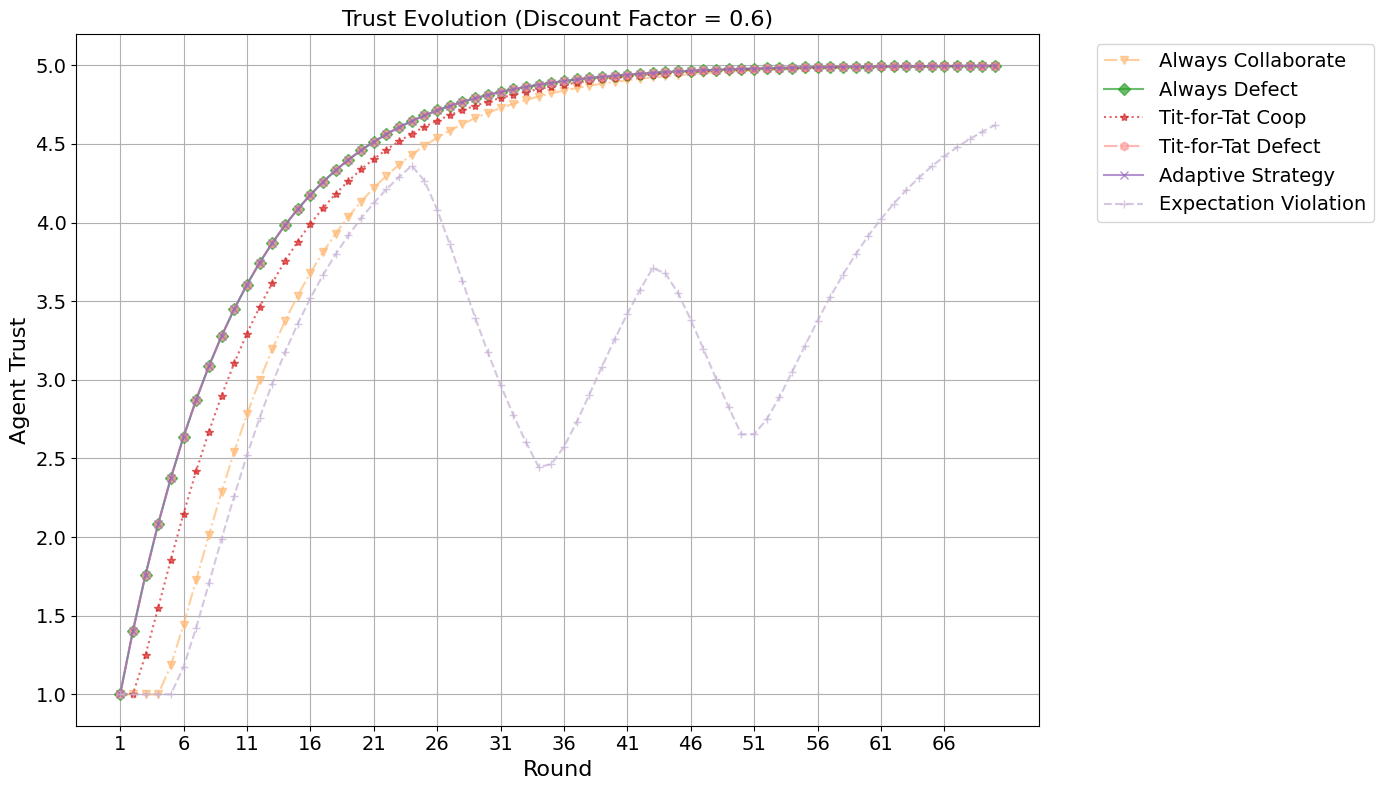

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a distinct color palette (using seaborn's "tab10" or "tab20" for more colors)
colors = sns.color_palette("tab20", 10)  # 10 distinct colors for 10 strategies

# Define line styles and markers to differentiate the lines
line_styles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

# Visualize Trust Evolution
plt.figure(figsize=(14, 8))  # Increase figure size

plt.plot(df_collab["Round"], df_collab["Agent_Trust"], label="Always Collaborate", 
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_defect["Round"], df_defect["Agent_Trust"], label="Always Defect", 
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_tit_for_tat_coop["Round"], df_tit_for_tat_coop["Agent_Trust"], label="Tit-for-Tat Coop", 
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_tit_for_tat_defect["Round"], df_tit_for_tat_defect["Agent_Trust"], label="Tit-for-Tat Defect", 
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_adaptive["Round"], df_adaptive["Agent_Trust"], label="Adaptive Strategy", 
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_expect_violation["Round"], df_expect_violation["Agent_Trust"], label="Expectation Violation", 
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Trust", fontsize=16)
plt.title(f"Trust Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

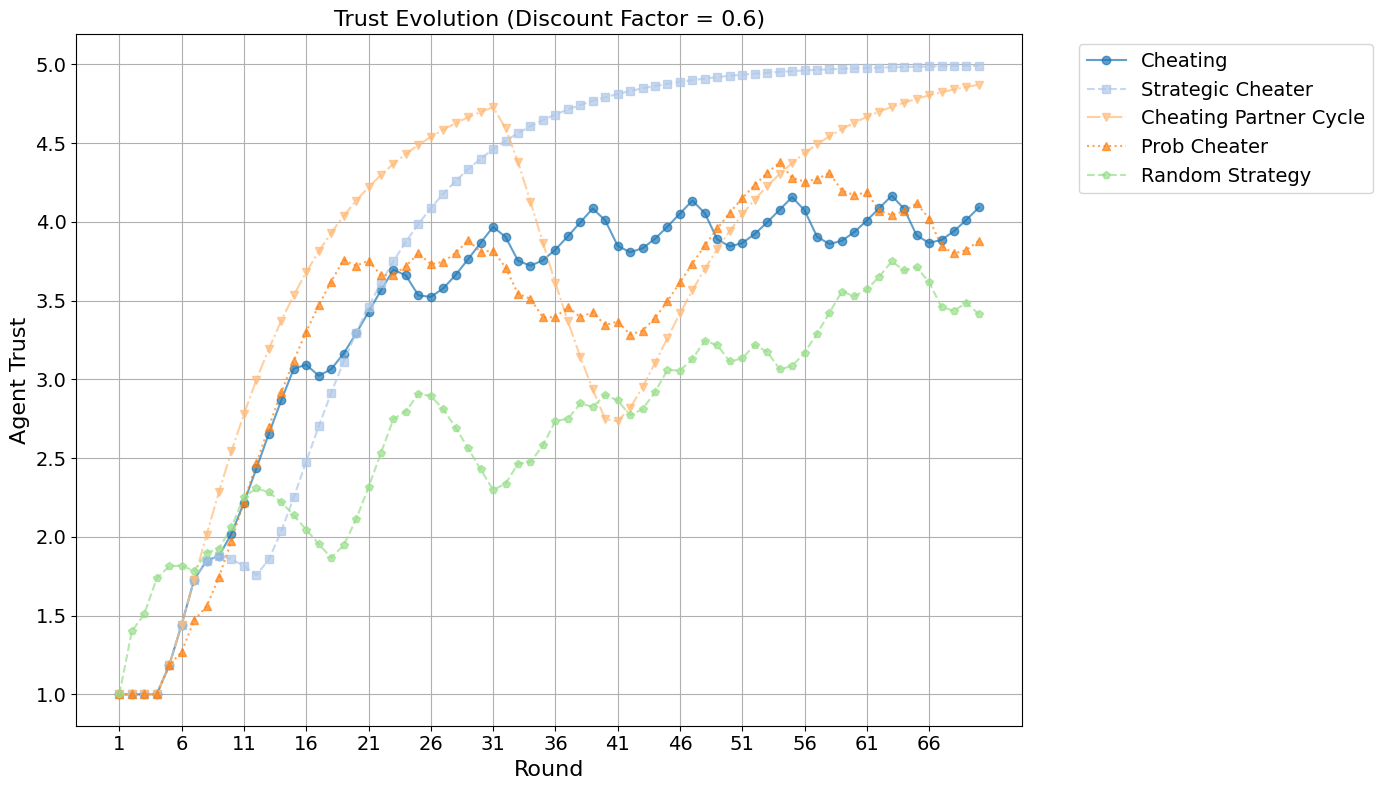

In [28]:
plt.figure(figsize=(14, 8))  # Increase figure size
plt.plot(df_cheating["Round"], df_cheating["Agent_Trust"], label="Cheating", 
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)
plt.plot(df_strategic_cheater["Round"], df_strategic_cheater["Agent_Trust"], label="Strategic Cheater", 
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)
plt.plot(df_cheating_partner_cycle["Round"], df_cheating_partner_cycle["Agent_Trust"], label="Cheating Partner Cycle",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)
plt.plot(df_prob_cheater["Round"], df_prob_cheater["Agent_Trust"], label="Prob Cheater", 
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)
plt.plot(df_random["Round"], df_random["Agent_Trust"], label="Random Strategy", 
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Trust", fontsize=16)
plt.title(f"Trust Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

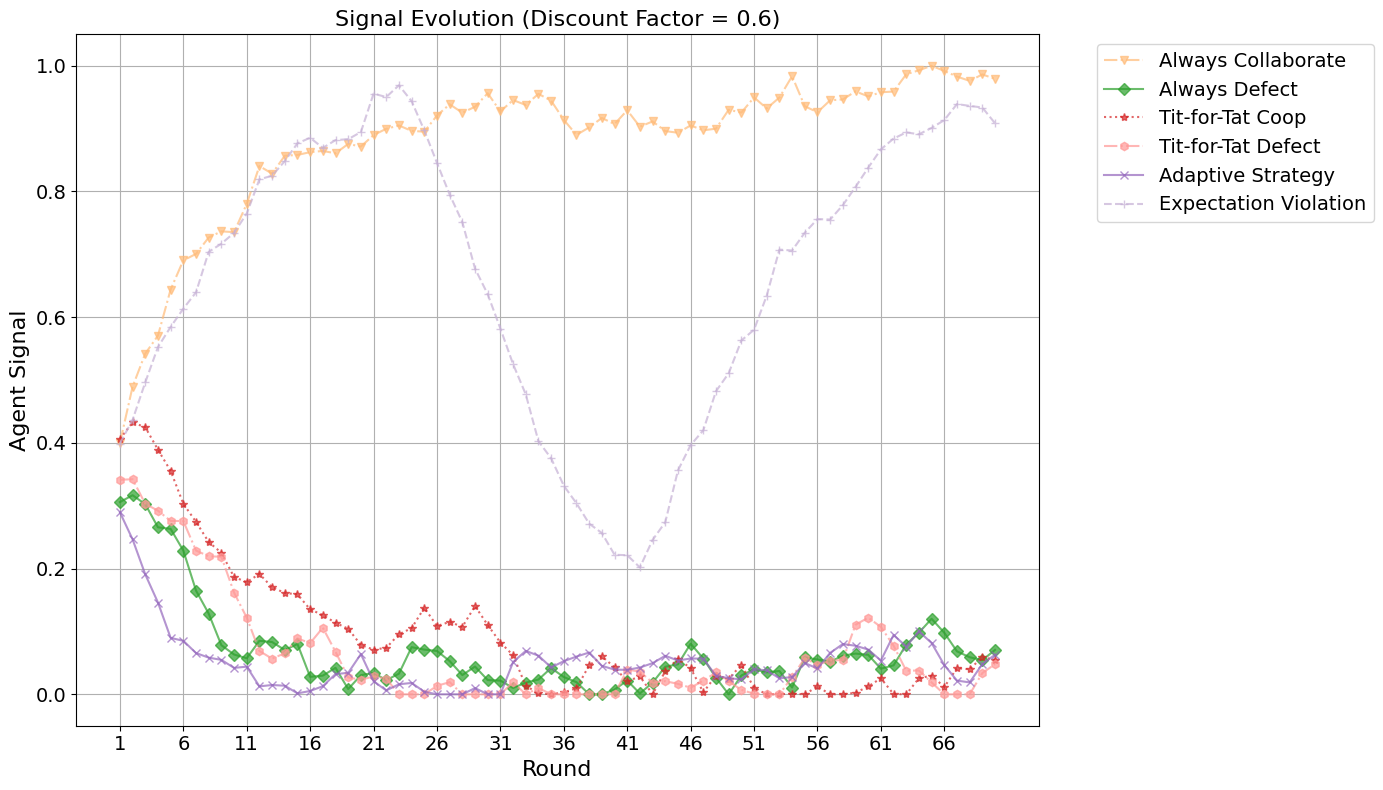

In [29]:
# Visualize Signal Evolution
plt.figure(figsize=(14, 8))  # Increase figure size

plt.plot(df_collab["Round"], df_collab["Agent_Signal"], label="Always Collaborate", 
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_defect["Round"], df_defect["Agent_Signal"], label="Always Defect", 
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_tit_for_tat_coop["Round"], df_tit_for_tat_coop["Agent_Signal"], label="Tit-for-Tat Coop", 
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_tit_for_tat_defect["Round"], df_tit_for_tat_defect["Agent_Signal"], label="Tit-for-Tat Defect", 
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_adaptive["Round"], df_adaptive["Agent_Signal"], label="Adaptive Strategy", 
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_expect_violation["Round"], df_expect_violation["Agent_Signal"], label="Expectation Violation", 
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)


plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Signal", fontsize=16)
plt.title(f"Signal Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

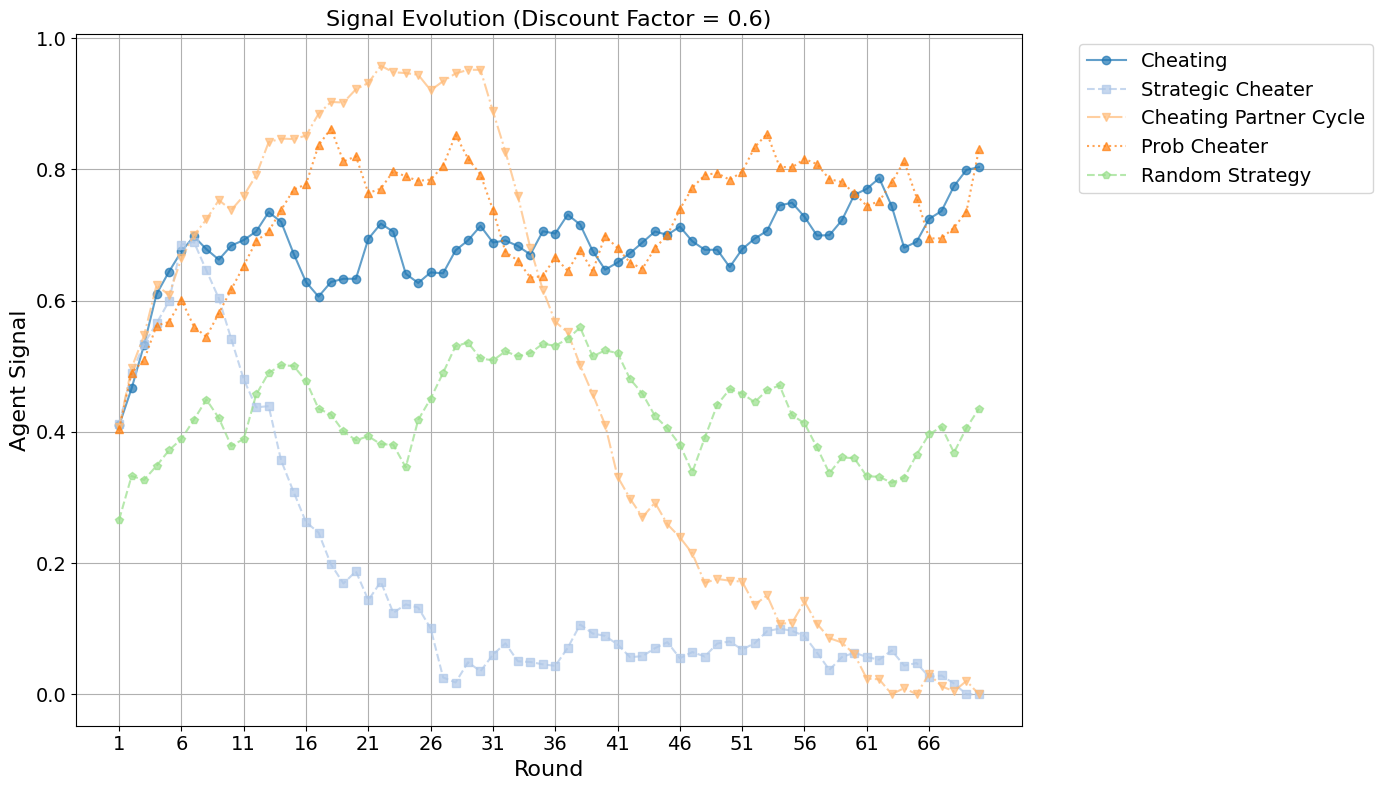

In [30]:
plt.figure(figsize=(14, 8))  # Increase figure size
plt.plot(df_cheating["Round"], df_cheating["Agent_Signal"], label="Cheating", 
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)
plt.plot(df_strategic_cheater["Round"], df_strategic_cheater["Agent_Signal"], label="Strategic Cheater", 
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)
plt.plot(df_cheating_partner_cycle["Round"], df_cheating_partner_cycle["Agent_Signal"], label="Cheating Partner Cycle",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)
plt.plot(df_prob_cheater["Round"], df_prob_cheater["Agent_Signal"], label="Prob Cheater", 
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)
plt.plot(df_random["Round"], df_random["Agent_Signal"], label="Random Strategy", 
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Signal", fontsize=16)
plt.title(f"Signal Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside 
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

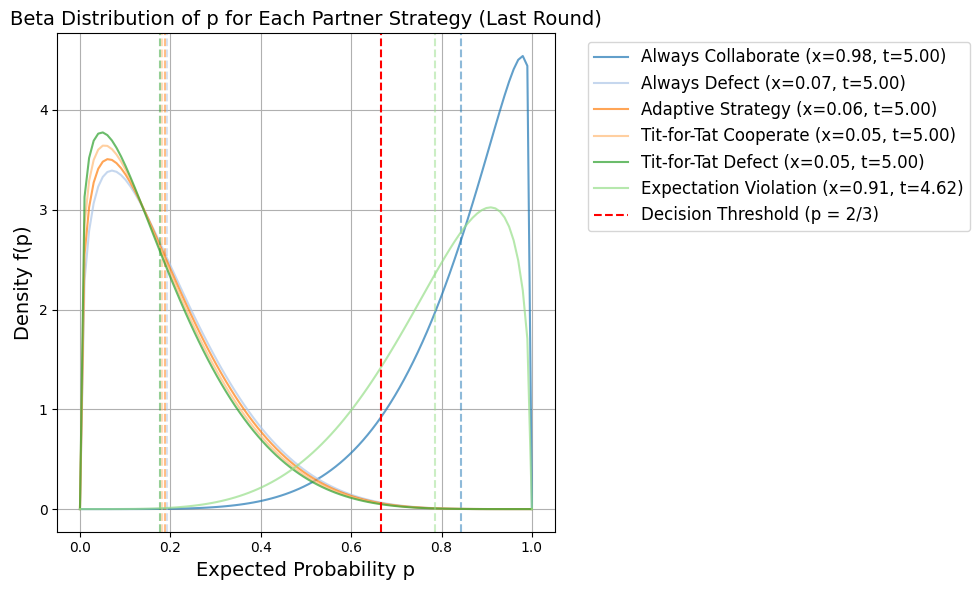

Decision-Making Trends in the Last Round:
Always Collaborate: p = 0.842, Choice = Stag
Always Defect: p = 0.193, Choice = Hare
Adaptive Strategy: p = 0.188, Choice = Hare
Tit-for-Tat Cooperate: p = 0.182, Choice = Hare
Tit-for-Tat Defect: p = 0.177, Choice = Hare
Expectation Violation: p = 0.785, Choice = Stag


In [31]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# List of DataFrames and their corresponding strategy names
strategies = [
    ("Always Collaborate", df_collab),
    ("Always Defect", df_defect),
    ("Adaptive Strategy", df_adaptive),
    ("Tit-for-Tat Cooperate", df_tit_for_tat_coop),
    ("Tit-for-Tat Defect", df_tit_for_tat_defect),
    ("Expectation Violation", df_expect_violation)
]

# Get x and t from the last round for each strategy
last_round_data = {}
for name, df in strategies:
    last_row = df.iloc[-1]  # Last round
    x = last_row["Agent_Signal"]
    t = last_row["Agent_Trust"]
    last_round_data[name] = (x, t)

# Plot the Beta distribution of p for each strategy
p = np.linspace(0, 1, 100)  # Values of p from 0 to 1
plt.figure(figsize=(10, 6))

# Use the same colors as in your previous plots for consistency
colors = sns.color_palette("tab20", 10)

for idx, (name, (x, t)) in enumerate(last_round_data.items()):
    # Compute α and β
    alpha = 1 + x * t
    beta = 1 + (1 - x) * t
    # Compute the mean E[p]
    E_p = (1 + x * t) / (2 + t)
    # Plot the Beta distribution
    plt.plot(p, stats.beta.pdf(p, alpha, beta), label=f"{name} (x={x:.2f}, t={t:.2f})",
             color=colors[idx], alpha=0.7)
    # Mark the mean E[p] with a vertical line
    plt.axvline(x=E_p, color=colors[idx], linestyle='--', alpha=0.5)
# Add the decision threshold
plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')

plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Beta Distribution of p for Each Partner Strategy (Last Round)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# Compare with decision-making trends
print("Decision-Making Trends in the Last Round:")
for name, df in strategies:
    last_choice = df.iloc[-1]["Agent_Choice"]
    last_p = (1 + df.iloc[-1]["Agent_Signal"] * df.iloc[-1]["Agent_Trust"]) / (2 + df.iloc[-1]["Agent_Trust"])
    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")

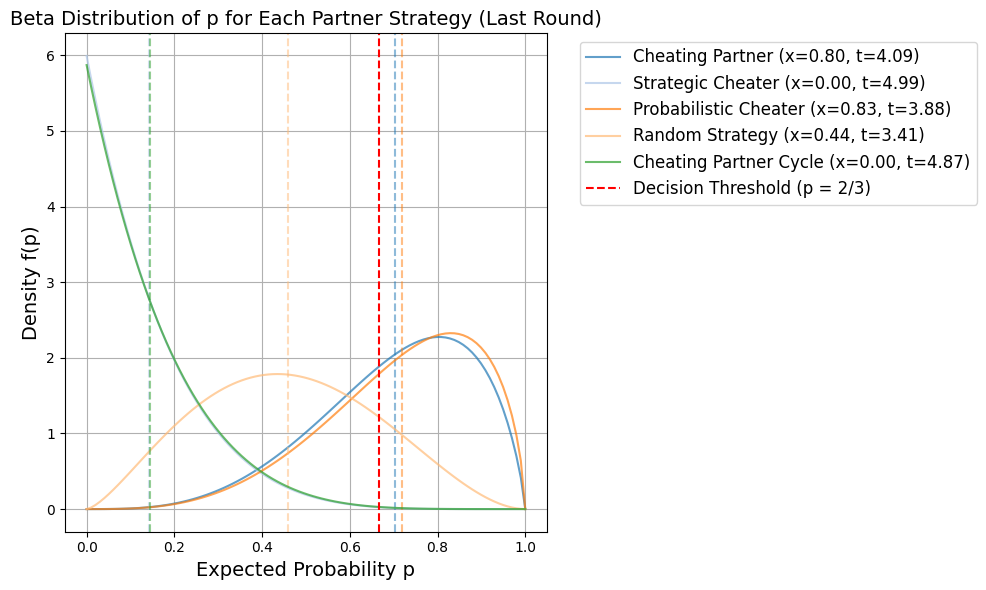

Decision-Making Trends in the Last Round:
Cheating Partner: p = 0.704, Choice = Stag
Strategic Cheater: p = 0.143, Choice = Hare
Probabilistic Cheater: p = 0.718, Choice = Hare
Random Strategy: p = 0.459, Choice = Hare
Cheating Partner Cycle: p = 0.146, Choice = Hare


In [32]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# List of DataFrames and their corresponding strategy names
strategies = [
    ("Cheating Partner", df_cheating),
    ("Strategic Cheater", df_strategic_cheater),
    ("Probabilistic Cheater", df_prob_cheater),
    ("Random Strategy", df_random),
    ("Cheating Partner Cycle", df_cheating_partner_cycle)

]

# Get x and t from the last round for each strategy
last_round_data = {}
for name, df in strategies:
    last_row = df.iloc[-1]  # Last round
    x = last_row["Agent_Signal"]
    t = last_row["Agent_Trust"]
    last_round_data[name] = (x, t)

# Plot the Beta distribution of p for each strategy
p = np.linspace(0, 1, 100)  # Values of p from 0 to 1
plt.figure(figsize=(10, 6))

# Use the same colors as in your previous plots for consistency
colors = sns.color_palette("tab20", 10)

for idx, (name, (x, t)) in enumerate(last_round_data.items()):
    # Compute α and β
    alpha = 1 + x * t
    beta = 1 + (1 - x) * t
    # Compute the mean E[p]
    E_p = (1 + x * t) / (2 + t)
    # Plot the Beta distribution
    plt.plot(p, stats.beta.pdf(p, alpha, beta), label=f"{name} (x={x:.2f}, t={t:.2f})",
             color=colors[idx], alpha=0.7)
    # Mark the mean E[p] with a vertical line
    plt.axvline(x=E_p, color=colors[idx], linestyle='--', alpha=0.5)

# Add the decision threshold
plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')

plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Beta Distribution of p for Each Partner Strategy (Last Round)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# Compare with decision-making trends
print("Decision-Making Trends in the Last Round:")
for name, df in strategies:
    last_choice = df.iloc[-1]["Agent_Choice"]
    last_p = (1 + df.iloc[-1]["Agent_Signal"] * df.iloc[-1]["Agent_Trust"]) / (2 + df.iloc[-1]["Agent_Trust"])
    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")

In [33]:
def cooperation_rate(df, who="Agent_Choice"):
    return df[who].mean()  # fraction of rounds with 1 (cooperate)

print("Agent coop rate:", cooperation_rate(df_tit_for_tat_coop))
print("Partner coop rate:", cooperation_rate(df_tit_for_tat_coop, who="Partner_Choice"))


Agent coop rate: 0.0
Partner coop rate: 0.014285714285714285


In [34]:
def add_payoffs(df):
    df = df.copy()
    p1 = df["Agent_Choice"].astype(int).to_numpy()
    p2 = df["Partner_Choice"].astype(int).to_numpy()
    df["Agent_Payoff"] = payoff[p1, p2, 0]
    df["Partner_Payoff"] = payoff[p1, p2, 1]
    return df


In [35]:
df_cheating = pd.DataFrame(sim_results_cheating)
df_cheating_partner_cycle = pd.DataFrame(sim_results_cheating_partner_cycle)
df_prob_cheater = pd.DataFrame(sim_results_probabilistic)
df_strategic_cheater = pd.DataFrame(sim_results_strategic_cheater)
df_tit_for_tat_coop = pd.DataFrame(sim_results_tit_for_tat_coop)
df_tit_for_tat_defect = pd.DataFrame(sim_results_tit_for_tat_defect)
df_collab = pd.DataFrame(sim_results_collab)
df_defect = pd.DataFrame(sim_results_defect)
df_random = pd.DataFrame(sim_results_random)
df_adaptive = pd.DataFrame(sim_results_adaptive)
df_expect_violation = pd.DataFrame(sim_results_expect_violation)

In [36]:
df_payoff_tit_coop = add_payoffs(df_tit_for_tat_coop)
print("Total agent payoff:", df_payoff_tit_coop["Agent_Payoff"].sum())
print("Total partner payoff:", df_payoff_tit_coop["Partner_Payoff"].sum())
print("Average per round:", df_payoff_tit_coop["Agent_Payoff"].mean())
df_payoff_tit_def = add_payoffs(df_tit_for_tat_defect)
print("Total agent payoff:", df_payoff_tit_def["Agent_Payoff"].sum())
print("Total partner payoff:", df_payoff_tit_def["Partner_Payoff"].sum())
print("Average per round:", df_payoff_tit_def["Agent_Payoff"].mean())
df_payoff_expt_violation = add_payoffs(df_expect_violation)
print("Total agent payoff:", df_payoff_expt_violation["Agent_Payoff"].sum())
print("Total partner payoff:", df_payoff_expt_violation["Partner_Payoff"].sum())
print("Average per round:", df_payoff_expt_violation["Agent_Payoff"].mean())
df_payoff_cheating = add_payoffs(df_cheating)
print("Total agent payoff:", df_payoff_cheating["Agent_Payoff"].sum())
print("Total partner payoff:", df_payoff_cheating["Partner_Payoff"].sum())
print("Average per round:", df_payoff_cheating["Agent_Payoff"].mean())
df_payoff_cheating_partner_cycle = add_payoffs(df_cheating_partner_cycle)
print("Total agent payoff:", df_payoff_cheating_partner_cycle["Agent_Payoff"].sum())
print("Total partner payoff:", df_payoff_cheating_partner_cycle["Partner_Payoff"].sum())
print("Average per round:", df_payoff_cheating_partner_cycle["Agent_Payoff"].mean())
df_payoff_prob_cheater = add_payoffs(df_prob_cheater)
print("Total agent payoff:", df_payoff_prob_cheater["Agent_Payoff"].sum())
print("Total partner payoff:", df_payoff_prob_cheater["Partner_Payoff"].sum())
print("Average per round:", df_payoff_prob_cheater["Agent_Payoff"].mean())
df_payoff_strategic_cheater = add_payoffs(df_strategic_cheater)
print("Total agent payoff:", df_payoff_strategic_cheater["Agent_Payoff"].sum())
print("Total partner payoff:", df_payoff_strategic_cheater["Partner_Payoff"].sum())
print("Average per round:", df_payoff_strategic_cheater["Agent_Payoff"].mean())
df_payoff_collab = add_payoffs(df_collab)
print("Total agent payoff:", df_payoff_collab["Agent_Payoff"].sum())
print("Total partner payoff:", df_payoff_collab["Partner_Payoff"].sum())
print("Average per round:", df_payoff_collab["Agent_Payoff"].mean())
df_payoff_defect = add_payoffs(df_defect)
print("Total agent payoff:", df_payoff_defect["Agent_Payoff"].sum())        
print("Total partner payoff:", df_payoff_defect["Partner_Payoff"].sum())
print("Average per round:", df_payoff_defect["Agent_Payoff"].mean())
df_payoff_random = add_payoffs(df_random)
print("Total agent payoff:", df_payoff_random["Agent_Payoff"].sum())   
print("Total partner payoff:", df_payoff_random["Partner_Payoff"].sum())
print("Average per round:", df_payoff_random["Agent_Payoff"].mean())
df_payoff_adaptive = add_payoffs(df_adaptive)
print("Total agent payoff:", df_payoff_adaptive["Agent_Payoff"].sum())  
print("Total partner payoff:", df_payoff_adaptive["Partner_Payoff"].sum())
print("Average per round:", df_payoff_adaptive["Agent_Payoff"].mean())


Total agent payoff: 141
Total partner payoff: 138
Average per round: 2.0142857142857142
Total agent payoff: 140
Total partner payoff: 140
Average per round: 2.0
Total agent payoff: 204
Total partner payoff: 135
Average per round: 2.914285714285714
Total agent payoff: 194
Total partner payoff: 50
Average per round: 2.7714285714285714
Total agent payoff: 180
Total partner payoff: 156
Average per round: 2.5714285714285716
Total agent payoff: 196
Total partner payoff: 136
Average per round: 2.8
Total agent payoff: 146
Total partner payoff: 128
Average per round: 2.085714285714286
Total agent payoff: 268
Total partner payoff: 232
Average per round: 3.8285714285714287
Total agent payoff: 140
Total partner payoff: 140
Average per round: 2.0
Total agent payoff: 173
Total partner payoff: 74
Average per round: 2.4714285714285715
Total agent payoff: 140
Total partner payoff: 140
Average per round: 2.0


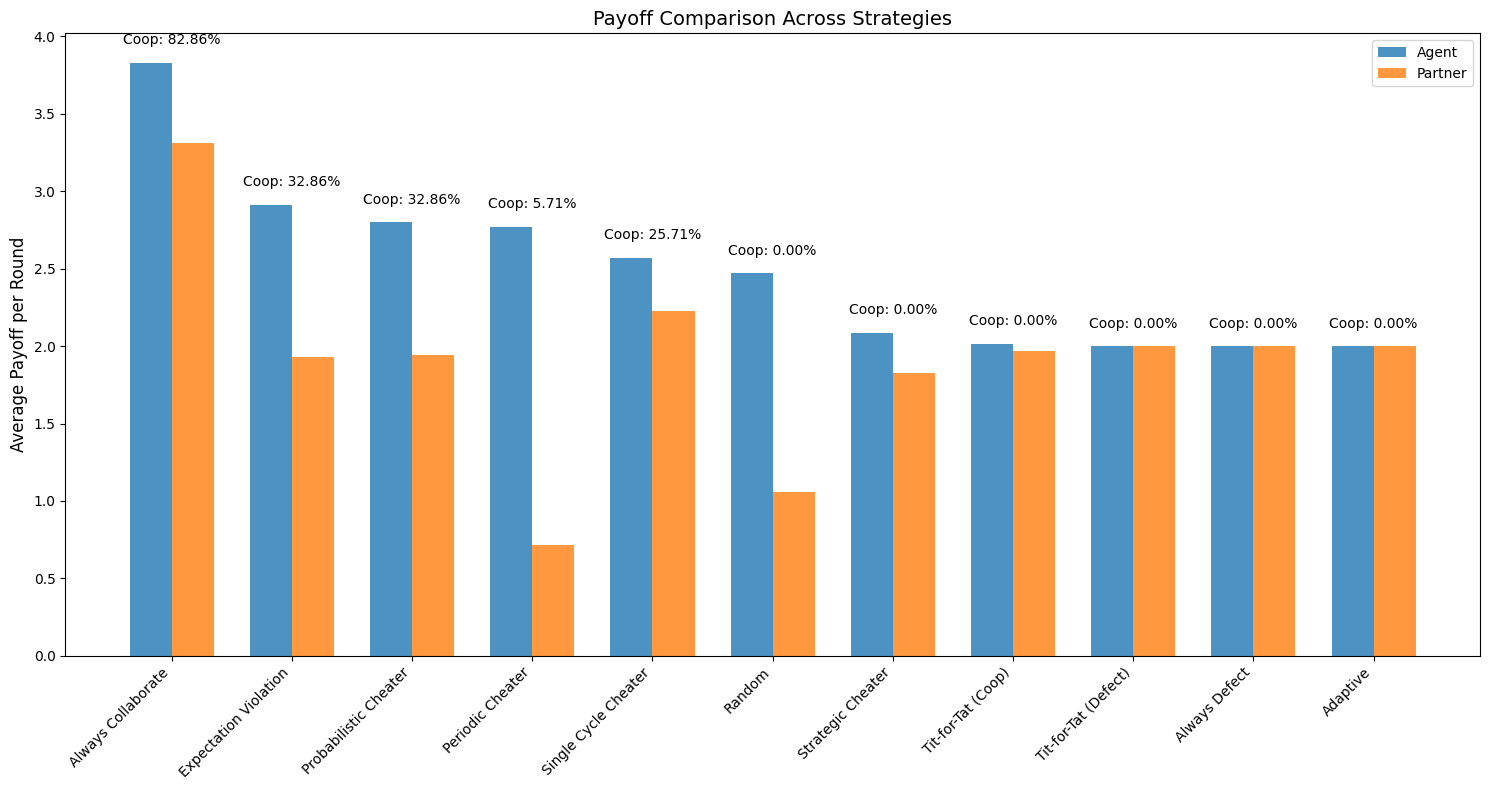


Detailed Strategy Analysis:
             Strategy  Total Agent Payoff  Total Partner Payoff  Avg Agent Payoff  Avg Partner Payoff  Mutual Cooperation Rate
   Always Collaborate                 268                   232              3.83                3.31                     0.83
Expectation Violation                 204                   135              2.91                1.93                     0.33
Probabilistic Cheater                 196                   136              2.80                1.94                     0.33
     Periodic Cheater                 194                    50              2.77                0.71                     0.06
 Single Cycle Cheater                 180                   156              2.57                2.23                     0.26
               Random                 173                    74              2.47                1.06                     0.00
    Strategic Cheater                 146                   128              2.09 

In [37]:
def analyze_payoffs(strategy_name: str, df: pd.DataFrame) -> dict:
    """Analyze payoffs for a given strategy."""
    df_with_payoff = add_payoffs(df)
    return {
        'Strategy': strategy_name,
        'Total Agent Payoff': df_with_payoff['Agent_Payoff'].sum(),
        'Total Partner Payoff': df_with_payoff['Partner_Payoff'].sum(),
        'Avg Agent Payoff': df_with_payoff['Agent_Payoff'].mean(),
        'Avg Partner Payoff': df_with_payoff['Partner_Payoff'].mean(),
        'Mutual Cooperation Rate': (df_with_payoff['Agent_Choice'] & df_with_payoff['Partner_Choice']).mean()
    }

# Analyze all strategies
strategy_results = pd.DataFrame([
    analyze_payoffs("Tit-for-Tat (Coop)", df_tit_for_tat_coop),
    analyze_payoffs("Tit-for-Tat (Defect)", df_tit_for_tat_defect),
    analyze_payoffs("Expectation Violation", df_expect_violation),
    analyze_payoffs("Periodic Cheater", df_cheating),
    analyze_payoffs("Single Cycle Cheater", df_cheating_partner_cycle),
    analyze_payoffs("Probabilistic Cheater", df_prob_cheater),
    analyze_payoffs("Strategic Cheater", df_strategic_cheater),
    analyze_payoffs("Always Collaborate", df_collab),
    analyze_payoffs("Always Defect", df_defect),
    analyze_payoffs("Random", df_random),
    analyze_payoffs("Adaptive", df_adaptive)
])

# Sort by total agent payoff to see most successful strategies
strategy_results = strategy_results.sort_values('Total Agent Payoff', ascending=False)

# Create visualization
plt.figure(figsize=(15, 8))
x = np.arange(len(strategy_results))
width = 0.35

plt.bar(x - width/2, strategy_results['Avg Agent Payoff'], width, label='Agent', alpha=0.8)
plt.bar(x + width/2, strategy_results['Avg Partner Payoff'], width, label='Partner', alpha=0.8)

plt.ylabel('Average Payoff per Round', fontsize=12)
plt.title('Payoff Comparison Across Strategies', fontsize=14)
plt.xticks(x, strategy_results['Strategy'], rotation=45, ha='right')
plt.legend()

# Add cooperation rate as text on top of bars
for i, row in enumerate(strategy_results.itertuples()):
    plt.text(i, max(row._4, row._5) + 0.1, 
             f'Coop: {row._6:.2%}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Strategy Analysis:")
print(strategy_results.round(2).to_string(index=False))

In [38]:
df_expect_violation = pd.DataFrame(sim_results_expect_violation)
df_expect_violation

,Round,Agent_Choice,Partner_Choice,Agent_Signal,Agent_Trust
0,1,0,1,0.399011,1.000000
1,2,0,1,0.436655,1.000000
2,3,0,1,0.496319,1.000000
3,4,0,1,0.552470,1.000000
4,5,0,1,0.584468,1.000000
...,...,...,...,...,...
65,66,1,1,0.913559,4.421195
66,67,1,1,0.939015,4.479009
67,68,1,1,0.936190,4.531069
68,69,1,1,0.933525,4.577938
